In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
from desi_retriever.denali import get_specs
import matplotlib.cm as cm
import scipy.ndimage as sn

In [2]:
def print_simple_number(truth_table,object_type):
    total_N = len(truth_table)
    good_N = len(truth_table[truth_table['best_quality']>=2.5])
    very_good_N = len(truth_table[truth_table['best_quality']==4])
    tmp_table = truth_table.loc[truth_table['best_quality']>=2.5]
    number_of_consistent_z = len(tmp_table.loc[abs(tmp_table['best_z']-tmp_table['Redrock_z'])/(1+tmp_table['best_z'])<0.0033])
    
    print('Number of',object_type,':',total_N)
    print('Number of ',object_type,'with quality>=2.5:',good_N, ' | fration=',good_N*1.0/total_N)
    print('Number of ',object_type,'with quality==4:',very_good_N, ' | fration=',very_good_N*1.0/total_N)
    print('Number of ',object_type,'with consistent z (with quality>=2.5):',number_of_consistent_z, '| fraction=',number_of_consistent_z/total_N)
   
    number_star = len(tmp_table.loc[tmp_table['best_spectype']=='STAR'])
    number_galaxy = len(tmp_table.loc[tmp_table['best_spectype']=='GALAXY'])
    number_qso = len(tmp_table.loc[tmp_table['best_spectype']=='QSO'])
    print('---------')  
    print('Fraction of objects with quality>=2.5')
    print('Star:',number_star*1.0/good_N)
    print('Galaxy:',number_galaxy*1.0/good_N)    
    print('QSO:',number_qso*1.0/good_N)

    plt.hist(truth_table['best_quality'],bins=8,range=(0,4))
    plt.ylabel('Number')
    plt.xlabel('Quality')
    plt.yscale('log')
    plt.xlim(0,4)
  

In [3]:
def plot_redshift_distribution(truth_table,object_type):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    x_range = [0,max(truth_table.loc[truth_table['best_quality']>=2.5]['best_z'])]
    plt.hist(truth_table['best_z'],range=(x_range[0],x_range[1]),bins=20,color='b',label='All')
    plt.hist(truth_table.loc[truth_table['best_quality']>=2.5]['best_z'],range=(x_range[0],x_range[1]),bins=20,color='orange',label='quality>=2.5')
    plt.hist(truth_table.loc[truth_table['best_quality']==4]['best_z'],range=(x_range[0],x_range[1]),bins=20,color='g',label='quality=4')
    plt.yscale('log')
    plt.xlabel('Best z')
    plt.ylabel('Number')
    plt.legend()
    plt.title(object_type)
    
    plt.subplot(1,2,2)
    plt.scatter(truth_table.loc[truth_table['best_quality']>=2.5]['best_z'],truth_table.loc[truth_table['best_quality']>=2.5]['Redrock_z'],
                
                c=truth_table.loc[truth_table['best_quality']>=2.5]['best_quality'],cmap=cm.jet)
    plt.xlabel('Best z')
    plt.ylabel('Redrock z')
    plt.colorbar()

In [4]:
def plot_chi2_quality_distribution(truth_table):
    #plt.scatter(truth_table['best_quality'],truth_table['DELTACHI2'])
    #plt.ylim(1,100000)
    #plt.yscale('log')
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.hist(np.log10(truth_table['DELTACHI2']),label='All',bins=8,range=(0,5),color='b')
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']>=2.5]['DELTACHI2']),color='orange',label='flag>=2.5',bins=8,range=(0,5))
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']==4]['DELTACHI2']),color='g',label='flag=4',bins=8,range=(0,5),)
    plt.xlabel('$log_{10}$ delta chi$^{2}$')
    plt.ylabel('Number')
    plt.yscale('log')
    plt.legend()
    plt.subplot(1,2,2)
    
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']<2.5]['DELTACHI2']),color='grey',label='flag<2.5',bins=8,range=(0,5),histtype='step',lw=4)
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']>=2.5]['DELTACHI2']),color='orange',label='flag>=2.5',bins=8,range=(0,5),histtype='step',lw=4)
    #plt.hist(np.log10(truth_table.loc[truth_table['best_quality']==4]['DELTACHI2']),color='g',label='flag=4',bins=8,range=(0,5),histtype='step',lw=4)

    plt.xlabel('$log_{10}$ delta chi$^{2}$')
    plt.ylabel('Number')
    plt.yscale('log')
    plt.legend()    
    
    
    
    

In [5]:
def give_me_ra_dec_object_with_property_cut(truth_table, property_name, cut, if_print=True):
    tmp_table = truth_table.loc[(truth_table[property_name]>=cut[0]) & (truth_table[property_name]<cut[1])]
    if if_print==True:
        for i_object in range(0,len(tmp_table)):
            print(tmp_table['TARGET_RA'].values[i_object],tmp_table['TARGET_DEC'].values[i_object])
    
    return tmp_table

In [6]:
# The filenames are tentative. We will change the filenames.
on_nersc=False
if on_nersc==True:
    dir = '/global/cfs/cdirs/desi/sv/vi/TruthTables/Cascades/'
    BGS = pd.read_csv(dir+'BGS/'+'desi-vi_SV_cascades_combination_BGS_all_210521.csv')
    BGS['DELTACHI2']=BGS['Redrock_deltachi2']
    LRG = pd.read_csv(dir+'LRG/'+'desi-vi_SV_cascades_combination_LRG_all_210521.csv')
    LRG['DELTACHI2']=LRG['Redrock_deltachi2']
    ELG = pd.read_csv(dir+'ELG/'+'desi-vi_SV_cascades_combination_ELG_all_210521.csv')
    ELG['DELTACHI2']=ELG['Redrock_deltachi2']
    #ELG_80606 = pd.read_csv(dir+'ELG/'+'desi-vi_ELG_tile80606_nightdeep_merged_all_210218.csv')
else:
    #dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Truth_tables/'
    BGS = pd.read_csv('/Users/blue/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV_VI_cascades/Cascades/BGS/output/desi-vi_SV_cascades_combination_BGS_all_210521.csv')
    BGS['DELTACHI2']=BGS['Redrock_deltachi2']
    #LRG = pd.read_csv(dir+'desi-vi_LRG_tile80609_nightdeep_merged_all_210130.csv')
   

In [7]:
denali_all = Table.read('/Volumes/Elements/DESI/Denali/denali_alltiles_Allzinfo.fits')
denali_all = denali_all[denali_all['coadd_type']=='cumulative']

NameError: name 'catalog_BGS_match' is not defined

In [9]:
new_catalog_denali = denali_all['TARGETID','Z','subset','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC','LAST_NIGHT',
                              'EFFTIME_BRIGHT','FIBERFLUX_R','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER'].to_pandas()

# BGS main z_deep<0.9 and non-repeatable redshifts

Number of BGS : 1424
Number of  BGS with quality>=2.5: 1412  | fration= 0.9915730337078652
Number of  BGS with quality==4: 1325  | fration= 0.9304775280898876
Number of  BGS with consistent z (with quality>=2.5): 1361 | fraction= 0.9557584269662921
---------
Fraction of objects with quality>=2.5
Star: 0.09490084985835694
Galaxy: 0.8937677053824362
QSO: 0.0113314447592068


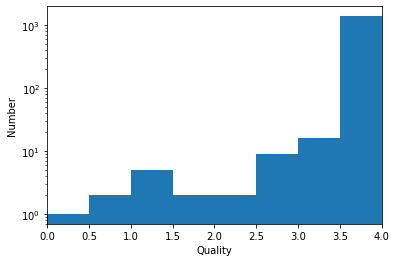

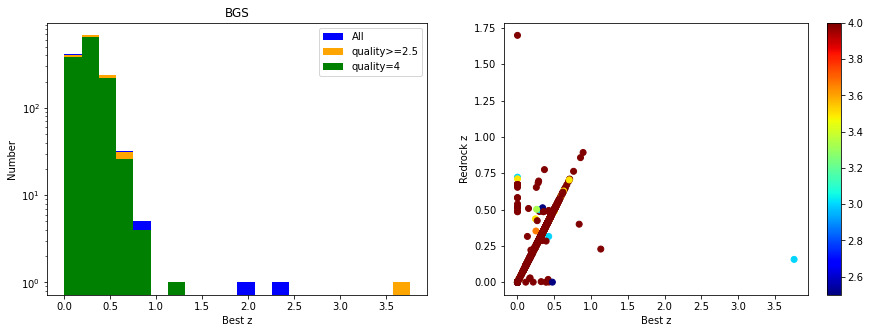

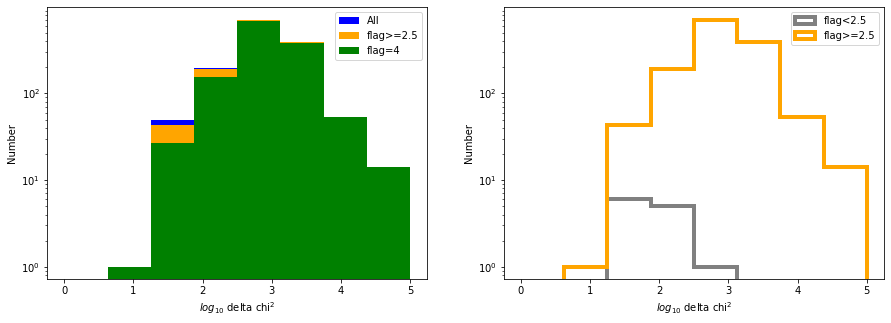

In [10]:
BGS_main = BGS[BGS['setting_name']=='sel0']
print_simple_number(BGS_main,'BGS')
plot_redshift_distribution(BGS_main,'BGS')
plot_chi2_quality_distribution(BGS_main)

In [22]:
catalog_BGS_match = BGS_main.merge(new_catalog_denali,on='TARGETID',how='left',suffixes=("_cascades","_denali"))
final_match_catalog = catalog_BGS_match[catalog_BGS_match['TILEID_cascades']==catalog_BGS_match['TILEID_denali']]
final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])
final_match_catalog['Redrock_z']=final_match_catalog['Z']



<ipython-input-22-cfa55cf747bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])
<ipython-input-22-cfa55cf747bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['Redrock_z']=final_match_catalog['Z']


Number of BGS : 1399
Number of  BGS with quality>=2.5: 1387  | fration= 0.9914224446032881
Number of  BGS with quality==4: 1301  | fration= 0.9299499642601858
Number of  BGS with consistent z (with quality>=2.5): 1335 | fraction= 0.954253037884203
---------
Fraction of objects with quality>=2.5
Star: 0.09084354722422494
Galaxy: 0.8976207642393655
QSO: 0.011535688536409516


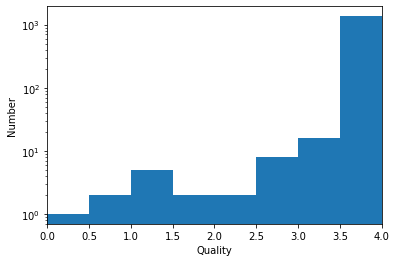

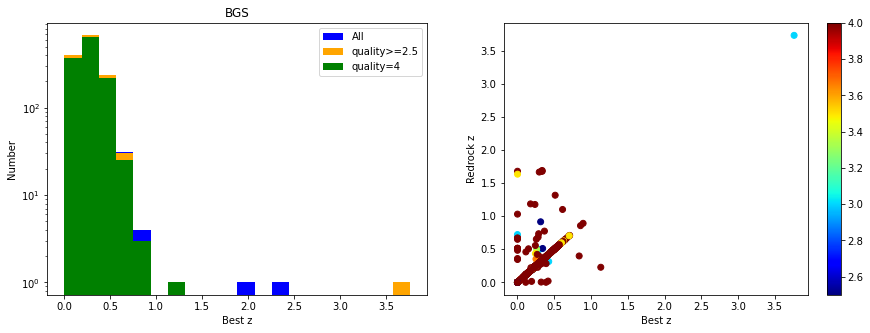

In [23]:
print_simple_number(final_match_catalog,'BGS')
plot_redshift_distribution(final_match_catalog,'BGS')

In [24]:
cut_catalog = final_match_catalog[(final_match_catalog['dz']>0.0033) & (final_match_catalog['best_quality']>=2.5)]

In [25]:
data_dict ={}
BGS_tile = np.array(cut_catalog['TILEID_denali'])
targetid = np.array(cut_catalog['TARGETID'])
fiberid = np.array(cut_catalog['FIBER'])
last_night = np.array(cut_catalog['LAST_NIGHT'])
print('Targetid, fiberid, tileid')
for i in range(0,len(fiberid)):
    if BGS_tile[i]==80619:
        last_night[i]=20210321
    if BGS_tile[i]==80612.0:
        last_night[i]=20201223 
    if BGS_tile[i]==80650.0:
        last_night[i]=20210322
    if BGS_tile[i]==80643.0:
        last_night[i]=20210308        
               
        
    print(targetid[i],fiberid[i],BGS_tile[i],last_night[i])
    data_dict[i]=get_specs(tileid=int(BGS_tile[i]), coadd_type='cumulative', night=int(last_night[i]), fiber=int(fiberid[i]))
   

Targetid, fiberid, tileid
39628435789714199 1158.0 80617.0 20201223.0
39628127722279021 512.0 80644.0 20210328.0
39628139436969006 990.0 80644.0 20210328.0
39628145279633366 934.0 80644.0 20210328.0
39628156956574951 1158.0 80644.0 20210328.0
39633147951843590 4055.0 80641.0 20210107.0
39628411710213463 1007.0 80664.0 20210224.0
39628417099892629 1474.0 80664.0 20210224.0
39633023792055235 2426.0 80642.0 20210107.0
39633278470196647 3074.0 80660.0 20210131.0
39633450491183196 2299.0 80619.0 20210321.0
39633567055087194 3167.0 80650.0 20210322.0
39628443918271514 2596.0 80664.0 20210224.0
39628451631599155 1216.0 80616.0 20201223.0
39627267172736791 2026.0 80674.0 20210116.0
39627616478567559 3994.0 80633.0 20210107.0
39627628457497115 842.0 80632.0 20210222.0
39627629069862704 4523.0 80612.0 20201223.0
39627640461592262 1216.0 80632.0 20210222.0
39627652490856700 1004.0 80632.0 20210222.0
39633457889935870 2675.0 80619.0 20210321.0
39633559467591247 693.0 80650.0 20210322.0
39633559534

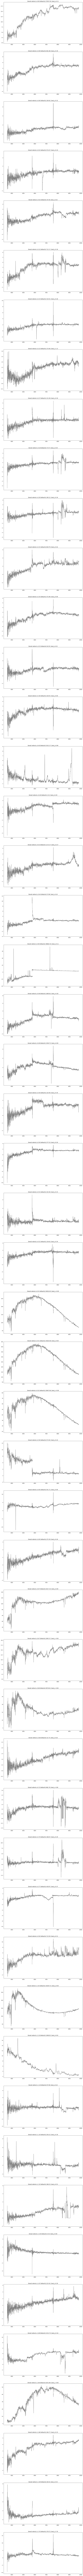

In [26]:
plt.figure(figsize=(15,500))
index = np.argsort(np.array(cut_catalog['Redrock_z']))

for i in range(0,len(index)):
    plt.subplot(len(index),1,i+1)
    plt.plot(data_dict[index[i]][0]['b_wavelength'],sn.median_filter(data_dict[index[i]][0]['b_flux'],10),color='grey')
    plt.plot(data_dict[index[i]][0]['r_wavelength'],sn.median_filter(data_dict[index[i]][0]['r_flux'],10),color='grey')
    plt.plot(data_dict[index[i]][0]['z_wavelength'],sn.median_filter(data_dict[index[i]][0]['z_flux'],10),color='grey')
    plt.title('Denali redrock z:%0.2f Deltachi2:%0.2f | best_z:%0.2f' % (np.array(cut_catalog['Redrock_z'])[index[i]],np.array(cut_catalog['DELTACHI2_denali'])[index[i]],np.array(cut_catalog['best_z'])[index[i]]))

In [27]:
for i in range(0,len(index)):
    print(targetid[index[i]],fiberid[index[i]],BGS_tile[index[i]],np.array(cut_catalog['Redrock_z'])[index[i]])


39628506107218476 658.0 80690.0 3.2425009963697756e-05
39632935116081802 2634.0 80651.0 0.0001483156219046326
39633178008227753 2680.0 80641.0 0.003559173603517275
39633562005143897 1115.0 80650.0 0.013946622096538679
39633103668382068 2675.0 80645.0 0.018772549250841566
39628516278403561 1216.0 80646.0 0.22110435045775198
39628417099892629 1474.0 80664.0 0.22685120754298302
39633561199839944 290.0 80650.0 0.22782059927841966
39628411710213463 1007.0 80664.0 0.2657877523178315
39632999477678514 1216.0 80642.0 0.2829388059905187
39628451631599155 1216.0 80616.0 0.2865573738995718
39628139436969006 990.0 80644.0 0.3147587350926835
39628145279633366 934.0 80644.0 0.3452512678898256
39627628457497115 842.0 80632.0 0.35238850115088205
39627665124101007 1911.0 80612.0 0.36019699449213183
39633278470196647 3074.0 80660.0 0.39879809190450655
39633023792055235 2426.0 80642.0 0.39960445063088
39628457084192201 2596.0 80617.0 0.4225768129069535
39633104092004577 3195.0 80653.0 0.4359682945966916


# BGS with z_deep>0.9

Number of BGS : 428
Number of  BGS with quality>=2.5: 411  | fration= 0.9602803738317757
Number of  BGS with quality==4: 373  | fration= 0.8714953271028038
Number of  BGS with consistent z (with quality>=2.5): 90 | fraction= 0.2102803738317757
---------
Fraction of objects with quality>=2.5
Star: 0.12895377128953772
Galaxy: 0.6423357664233577
QSO: 0.22871046228710462


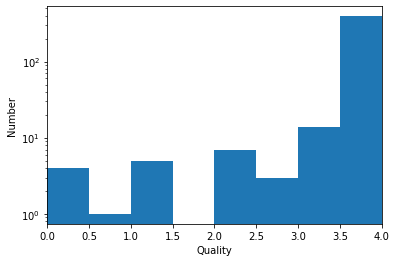

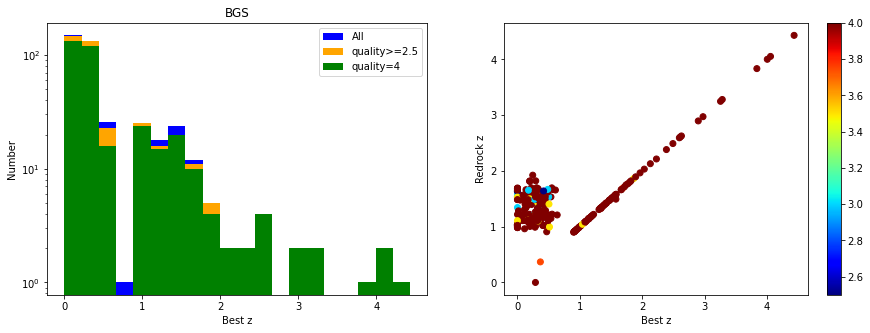

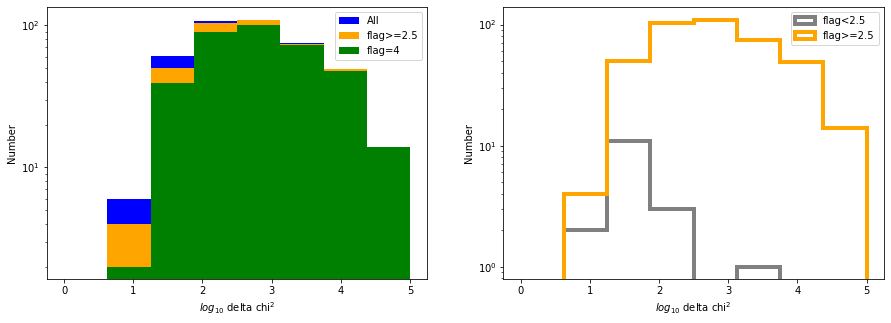

In [28]:
BGS_highz = BGS[BGS['setting_name']=='sel1']
print_simple_number(BGS_highz,'BGS')
plot_redshift_distribution(BGS_highz,'BGS')
plot_chi2_quality_distribution(BGS_highz)

In [40]:
catalog_BGS_match = BGS_highz.merge(new_catalog_denali,on='TARGETID',how='left',suffixes=("_cascades","_denali"))

### Comparing the Denali redshift and the best z

The consistency increases from 20% to 70%!!

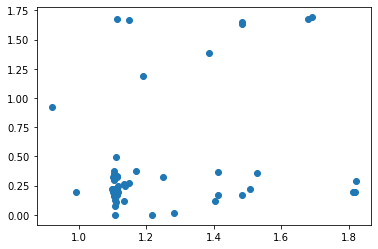

In [45]:
final_match_catalog = catalog_BGS_match[catalog_BGS_match['TILEID_cascades']==catalog_BGS_match['TILEID_denali']]
plt.scatter(final_match_catalog['Redrock_z'][final_match_catalog['TILEID_denali']==80643],final_match_catalog['Z'][final_match_catalog['TILEID_denali']==80643])

<ipython-input-42-fe0ee7eaa8ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['Redrock_z']=final_match_catalog['Z']


Number of BGS : 408
Number of  BGS with quality>=2.5: 391  | fration= 0.9583333333333334
Number of  BGS with quality==4: 355  | fration= 0.8700980392156863
Number of  BGS with consistent z (with quality>=2.5): 279 | fraction= 0.6838235294117647
---------
Fraction of objects with quality>=2.5
Star: 0.1278772378516624
Galaxy: 0.639386189258312
QSO: 0.23273657289002558


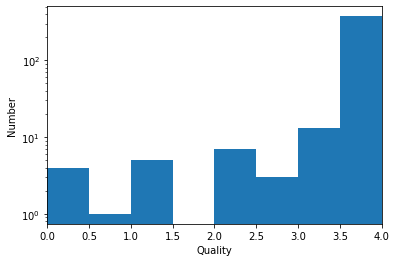

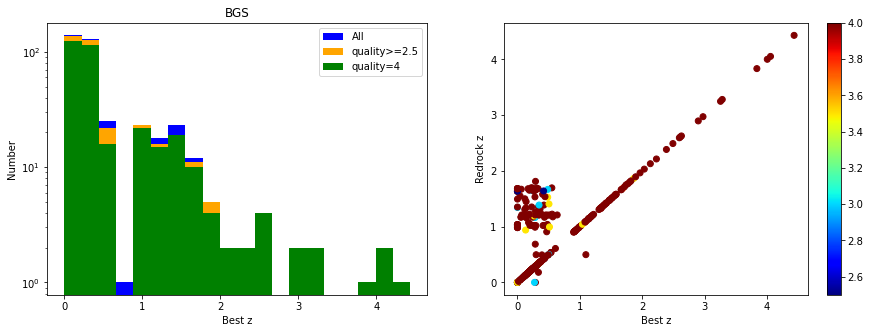

In [42]:
final_match_catalog['Redrock_z']=final_match_catalog['Z']
print_simple_number(final_match_catalog,'BGS')
plot_redshift_distribution(final_match_catalog,'BGS')
#plot_chi2_quality_distribution(final_match_catalog)

In [33]:
final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])

<ipython-input-33-d90767f6f3de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])


In [34]:
cut_catalog = final_match_catalog[(final_match_catalog['dz']>0.0033) & (final_match_catalog['best_quality']>=2.5)]

In [ ]:
#for i in range(0,112):
#    print(np.array(cut_catalog['TARGET_RA'])[i],np.array(cut_catalog['TARGET_DEC'])[i])

In [35]:
data_dict ={}
BGS_tile = np.array(cut_catalog['TILEID_denali'])
targetid = np.array(cut_catalog['TARGETID'])
fiberid = np.array(cut_catalog['FIBER'])
last_night = np.array(cut_catalog['LAST_NIGHT'])
print('Targetid, fiberid, tileid')
for i in range(0,len(fiberid)):
    if BGS_tile[i]==80619:
        last_night[i]=20210321
    if BGS_tile[i]==80612.0:
        last_night[i]=20201223        
    print(targetid[i],fiberid[i],BGS_tile[i],last_night[i])
    data_dict[i]=get_specs(tileid=int(BGS_tile[i]), coadd_type='cumulative', night=int(last_night[i]), fiber=int(fiberid[i]))
   

Targetid, fiberid, tileid
39633178029195897 3494.0 80641.0 20210107.0
39633182231889188 2938.0 80641.0 20210107.0
39633194760279591 1395.0 80676.0 20210109.0
39633227412936161 2700.0 80676.0 20210109.0
39633267158158203 2068.0 80660.0 20210131.0
39633278457613770 2664.0 80660.0 20210131.0
39633278944151202 3902.0 80711.0 20210306.0
39633349748198495 65.0 80738.0 20210318.0
39633435056147330 798.0 80619.0 20210321.0
39633437677585524 1216.0 80619.0 20210321.0
39633437685973404 1030.0 80619.0 20210321.0
39633447982991486 3330.0 80619.0 20210321.0
39633447991381533 3589.0 80619.0 20210321.0
39633448003962001 3645.0 80619.0 20210321.0
39633559547282852 4834.0 80655.0 20210322.0
39633561183061029 989.0 80650.0 20210322.0
39633561204033740 4593.0 80650.0 20210322.0
39633561254364476 4959.0 80655.0 20210322.0
39627163720222497 3665.0 80701.0 20210212.0
39627250437464205 3692.0 80674.0 20210116.0
39627635059331298 2.0 80612.0 20201223.0
39627646488811036 1431.0 80632.0 20210222.0
3962764649300

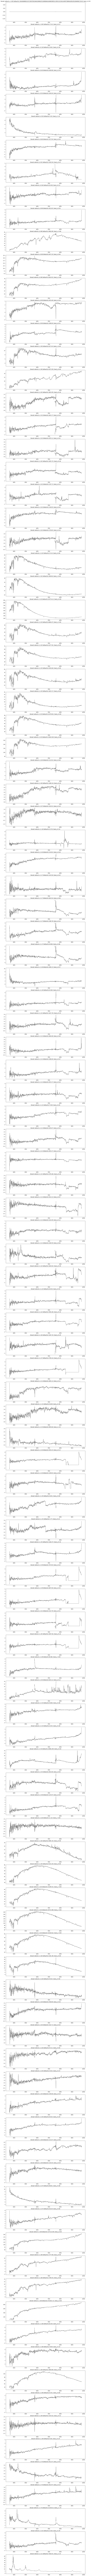

In [38]:
plt.figure(figsize=(15,500))
index = np.argsort(np.array(cut_catalog['Redrock_z']))

for i in range(0,len(index)):
    plt.subplot(len(index),1,i+1)
    plt.plot(data_dict[index[i]][0]['b_wavelength'],sn.median_filter(data_dict[index[i]][0]['b_flux'],20),color='grey')
    plt.plot(data_dict[index[i]][0]['r_wavelength'],sn.median_filter(data_dict[index[i]][0]['r_flux'],20),color='grey')
    plt.plot(data_dict[index[i]][0]['z_wavelength'],sn.median_filter(data_dict[index[i]][0]['z_flux'],20),color='grey')
    plt.title('Denali redrock z:%0.2f Deltachi2:%0.2f | best_z:%0.2f' % (np.array(cut_catalog['Redrock_z'])[index[i]],np.array(cut_catalog['DELTACHI2_denali'])[index[i]],np.array(cut_catalog['best_z'])[index[i]]))

In [39]:
for i in range(0,len(index)):
    print(targetid[index[i]],fiberid[index[i]],BGS_tile[index[i]],np.array(cut_catalog['Redrock_z'])[index[i]])


39627652520215381 3986.0 80632.0 -0.0019956912923479522
39628417099895377 1024.0 80664.0 -0.0008067760831335516
39633066825614895 4286.0 80645.0 0.1796483963357305
39633566388192288 2037.0 80650.0 0.49275502164486046
39627646488811036 1431.0 80632.0 0.4959991321474465
39633267158158203 2068.0 80660.0 0.49677197497575615
39628435676467359 4523.0 80616.0 0.684802617997012
39632989960799816 2665.0 80686.0 0.9072922698778295
39627671138730485 1788.0 80612.0 0.9382041926737372
39633161616885822 2674.0 80656.0 0.9790535100351521
39633561254364476 4959.0 80655.0 0.9823064325510014
39633152292950534 4328.0 80641.0 0.9823767989782703
39633018989579069 3572.0 80642.0 0.9825148502528883
39633561183061029 989.0 80650.0 0.9888459594366871
39628441024202966 4513.0 80616.0 0.9948919990043855
39633038216265978 2551.0 80642.0 0.9976625819930414
39633435056147330 798.0 80619.0 0.9986987691170218
39628472808637586 3589.0 80616.0 1.0193598624738351
39627755163226132 2672.0 80670.0 1.0195401610995602
39633